<a href="https://colab.research.google.com/github/Mateo-os/clustering/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U setuptools wheel
!pip install -U spacy
!pip install -U pip setuptools wheel
!pip install -U scikit-learn
!python -m spacy download es_core_news_sm

In [39]:
from collections import Counter
import spacy
import yaml
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE
import numpy as np
from nltk.cluster import kmeans,cosine_distance
import pandas as pd


Cargamos el corpus elegido, debido a el límite de Spacy, se limito el mismo para que no alcanzara los 10.000.000 de carácteres. Se corta en la linea 8076 para poder maximizar la cantidad de texto incluido sin cortar en medio de algun articulo

In [40]:
filename = "LaVanguardia.txt"

file = open(filename, 'r',encoding='latin-1')

lines = []
lines.extend(file.readline() for i in range(8076))

file.close()

text = ''.join(lines)

nlp = spacy.load('es_core_news_sm')
doc = nlp(text)


print("done")


done


In [41]:
def pretty(d, indent=0):
   for key, value in sorted(d.items()):
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

Separamos el texto en oraciones y eliminamos las de menos de 5 palabras (Con menos de 10 tenia pocas palabras). Luego filtramos las mismas para encontrar los tokens que genuinamente son palabras, y ademas guardamos los lemmas. Contamos las ocurrencias de cada lemma.

In [68]:

sents = [sent for sent in doc.sents if len(sent) > 5 ]

words = []
words_lemma = []
for sent in sents:
  for word in sent:
    if word.is_alpha:
      words.append(word)
      words_lemma.append(word.lemma_)

counts = Counter(words_lemma)


In [69]:
print(len(text))
print(len(doc))
print(len(words))
print(len(counts))

906752
173915
145671
13923


In [70]:
def addContext(feature ,context, threshold_c):
  for c_word in context:       
    c_lemma = c_word.lemma_ 
    key = c_lemma 
    if c_word.is_alpha and counts[c_lemma] > threshold_c: 
        if c_word.like_num: 
            key = "NUM__" 
        if not key in features: 
            features[key] = 0 
        features[key] += 1

Creamos un diccionario con las features del texto, relacion en el Part-Of-Speech y su relacion de dependecia sintáctica, ademas del contexto alrededor de la palabra objectivo

In [71]:

# Crear diccionario
dicc = {}
threshold_w = 50
threshold_c = 25
CONTEXT_WINDOW = 2

for word in words:
    w = word.lemma_
    if word.like_num or counts[w] < threshold_w:
        continue
    if not w in dicc:
        features = {}
    else:
        features = dicc[w]

    pos = "POS__" + word.pos_
    if not pos in features:
        features[pos] = 0
    features[pos] += 1

    dep = "DEP__" + word.dep_
    if not dep in features:
        features[dep] = 0
    features[dep] += 1

    context_left = doc[0: word.i] if word.i <= CONTEXT_WINDOW else doc[word.i - CONTEXT_WINDOW: word.i]
    addContext(features, context_left,threshold_c)

    context_right = doc[word.i + 1: len(doc)] if word.i + CONTEXT_WINDOW >= len(doc) else doc[word.i + 1: word.i + 1 + CONTEXT_WINDOW] 
    addContext(features, context_right,threshold_c)    
    dicc[w] = features
print(dicc)
print(len(dicc))

{'el': {'POS__DET': 15470, 'DEP__det': 15356, 'BARCELONA': 16, 'de': 6255, 'autopista': 23, 'quedar': 25, 'Generalitat': 135, 'decidir': 22, 'y': 1379, 'conocer': 21, 'que': 1986, 'Gobierno': 25, 'no': 240, 'a': 1258, 'por': 606, 'él': 699, 'precio': 38, 'mismo': 64, 'manera': 8, 'entre': 153, 'empresa': 80, 'cada': 9, 'del': 795, 'hacia': 29, 'mes': 36, 'embargo': 15, 'ayer': 96, 'hasta': 111, 'actual': 43, 'portavoz': 21, 'nuevo': 133, 'sistema': 15, 'en': 1952, 'cuenta': 16, 'al': 59, 'como': 207, 'posible': 12, 'tipo': 10, 'asegurar': 30, 'medida': 12, 'verde': 18, 'haber': 300, 'señalar': 20, 'con': 569, 'único': 26, 'administración': 19, 'explicar': 50, 'catalán': 38, 'puesto': 13, 'todo': 222, 'fuente': 17, 'compañía': 23, 'prever': 13, 'ley': 38, 'aprobar': 19, 'pero': 78, 'sí': 11, 'hora': 61, 'mañana': 22, 'área': 32, 'metropolitano': 20, 'mercado': 33, 'ser': 785, 'paseo': 29, 'vez': 44, 'ni': 45, 'plaza': 104, 'ronda': 34, 'metro': 36, 'centro': 60, 'En': 53, 'caso': 82, 'p

Separamos las key_wordos de las features, para poder pasar estas ultimas al vectorizador

In [72]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

Vectorizamos con stickit learn y normalizamos la matriz resultante

In [73]:
  v = DictVectorizer(sparse=False)
  matrix = v.fit_transform(features)
  matrix_normed = matrix / matrix.max(axis=0)

Reducimos la matrix elminando los elementos por debajo de la varianza

In [75]:
  variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
  threshold_v = 0.001
  red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)


TSN-e

In [76]:
#Se aplica el emmbeding tsn-e

tsne = TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

Grafiquitos bonitos

In [77]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

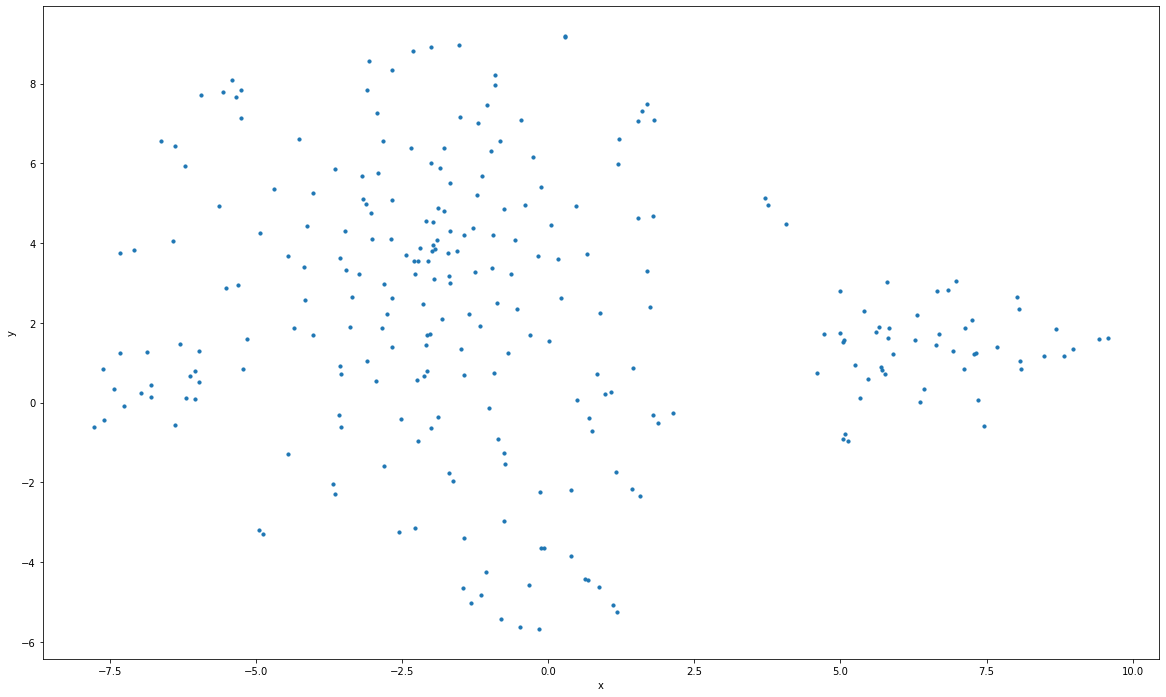

In [78]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [79]:
def plot_region(points,x_bounds, y_bounds):
  slce = points[
      (x_bounds[0] <= points.x) &
      (points.x <= x_bounds[1]) & 
      (y_bounds[0] <= points.y) &
      (points.y <= y_bounds[1])
  ]
  
  ax = slce.plot.scatter('x', 'y', s=35, figsize=(20, 12))
  for i, point in slce.iterrows():
      ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

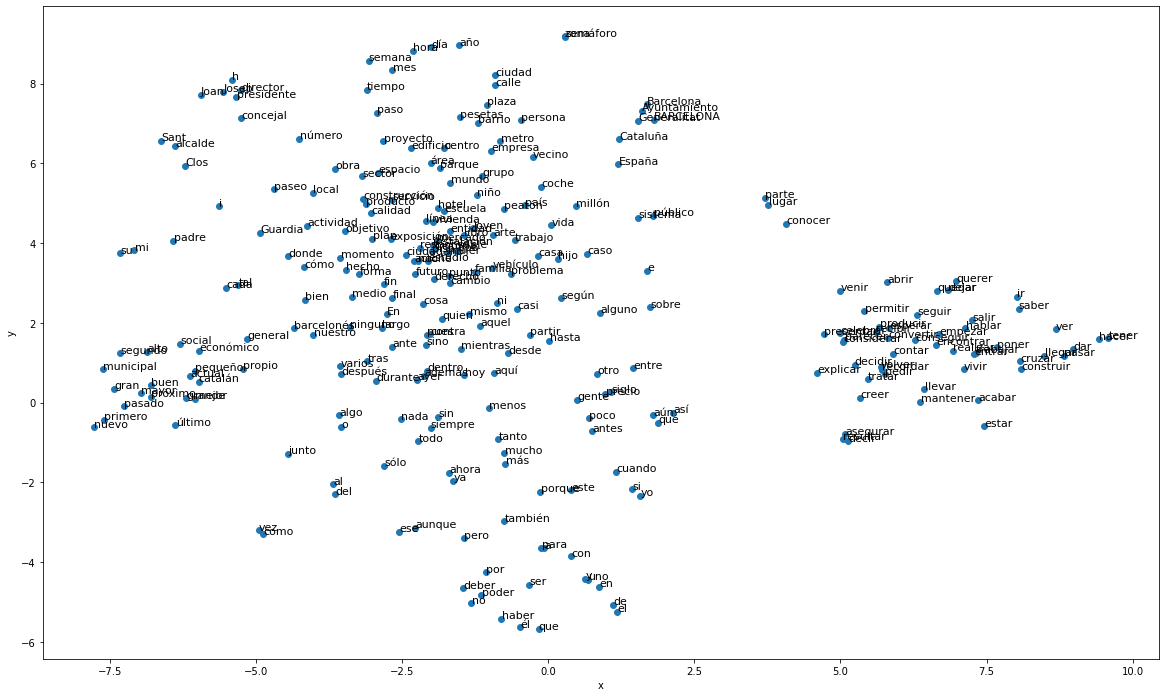

In [80]:

plot_region(pointsspacy,x_bounds=(-200, 200), y_bounds=(-200, 200))

EL *CLUSTERING*

In [81]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [82]:
clust50 =  clustering(50)
clust100 = clustering(100)
clust150 = clustering(150)

In [83]:
clusters = clust100

In [84]:
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "c"]
)

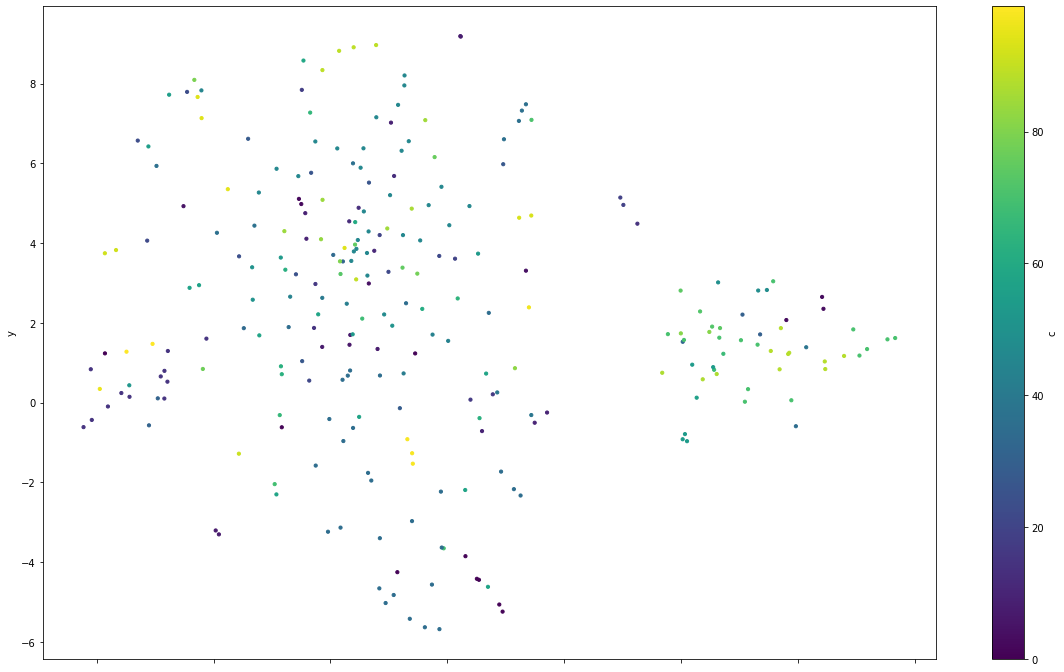

In [85]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [96]:
def plot_region_cluster(points,x_bounds, y_bounds,text=False):
    slce = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slce.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(10, 8))
    if not text: return
    for i, point in slce.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

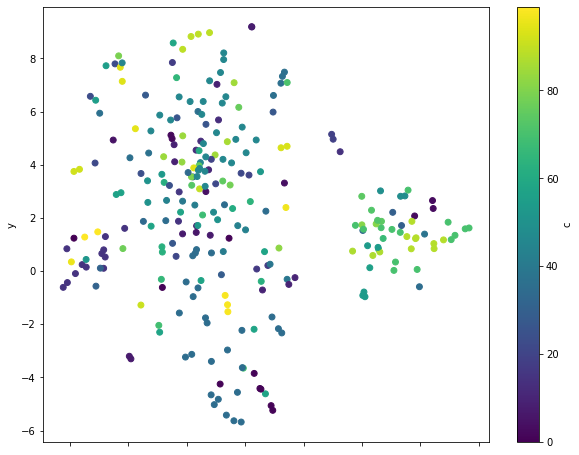

In [97]:
plot_region_cluster(pointscluster,x_bounds=(-200, 200), y_bounds=(-200,200))

In [88]:
def get_word_cluster(word_):
  return [word for word in key_words if clusters[key_words[word]] == clusters[key_words[word_]]]

Stop words: OK

In [89]:
# Stopwords
print(get_word_cluster('de'))

['el', 'de', 'y', 'uno', 'por', 'o', 'con', 'desde']


Palabras refentes a unidades de tiempo: OK

In [90]:

print(get_word_cluster('año'))

['año', 'mes', 'hora', 'día']


Uno pensaria que las palabras ordinales como 'primero' e 'último' estarian juntas. Quiero decir, incluso estan cerca en el grafico! Pues no... no para nada.

In [101]:
print(get_word_cluster('primero'))
print(get_word_cluster('último'))

['grande', 'último']


Curiosamente relaciona regiones (Barcelona con Cataluña) pero no la relaciona con España. Espero no estar usando una red entrenada con tintes politicos... No me pregunten porque BARCELONA en all-caps esta en su propio cluster poque no lo sé

In [98]:
#Ciudades
print(get_word_cluster('España'))
print(get_word_cluster('Barcelona'))
print(get_word_cluster('BARCELONA'))

['tras', 'España']
['Generalitat', 'área', 'Barcelona', 'Cataluña', 'Clos', 'Ayuntamiento', 'Guardia']
['BARCELONA']


Queria ver porque la palabrra 'millón' estaba en el dicc, porque en teoria no tendria que estar porque quito todas las que representan numeros... Pero honestamente no entiendo

In [92]:
print(get_word_cluster('millón'))

['empresa', 'sector', 'mercado', 'calle', 'plaza', 'metro', 'centro', 'local', 'arte', 'coche', 'vida', 'trabajo', 'mujer', 'proyecto', 'historia', 'obra', 'piso', 'ciudad', 'millón', 'pesetas', 'edificio', 'punto', 'parque', 'niño', 'escuela', 'entidad', 'país', 'estudio']
